# Local Interaction

**Tomohiro Kusano**  , **Yuya Furusawa**

*Graduate School of Economics, University of Tokyo*

This notebook demonstrates how to study local interaction model using the **`localint`** Python library.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from matplotlib.animation import FuncAnimation
from quantecon.game_theory.localint import LocalInteraction
from IPython.display import Image
from IPython.display import HTML

(**Note**: If you want to see the animation, please open this note via [nbviewer](http://nbviewer.jupyter.org/))

## Local Interaction Game

Let $\chi$ be a finite set of players and $P:\chi \times \chi \to \mathbb{R}_+$ be  a weighting function  that satisfies

* $P(x,x) = 0$ for all $x \in \chi$
* $P(x,y) = P(y,x)$ for all $x,y \in \chi$.

A *local interaction system* is the undirected graph induced by $(\chi, P)$. Note that $P$ can be represented by a matrix, which will be introduced as **"adjacency matrix"** in the next section, since $\chi$ is finite here (theoretically, we can assume $\chi$ is countably infinite).


Write $\Gamma (x) = \{ y \in X | P(x,y) > 0 \}$ for the set of neighbors of player $x \in X$

Denote 
\begin{eqnarray*}
P(y|x) = \frac{P(x,y)}{\sum_{y' \in \Gamma(x)} P(x,y')}
\end{eqnarray*}

$P(y|x)$ represents the normalized weights of the interactions from $x$ to $y$

For example, $(\chi, P)$, where $\chi = {0,1,2}$ and 

\begin{equation*}
P =
\begin{bmatrix}
0 & 1 & 3 \\
1 & 0 & 2 \\
3 & 2 & 0
\end{bmatrix}
\end{equation*}


represents the following local interaction system.

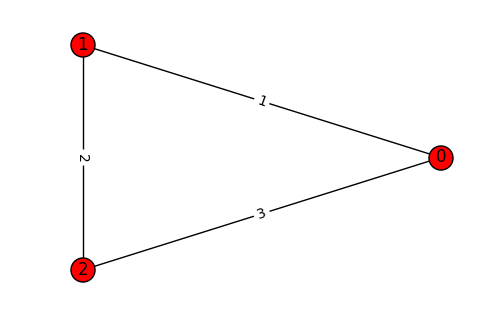

In [2]:
Image(filename='./localint_materials/figure_1.png')

The integer on each edge denote the corresponding weight on the edge.

In each period, given the local interaction system, each player plays a game constructing his/her belief, which is a distribution on the action space, according to the weights on the edges and what other players are taking.

For example, let's consider the above system. Suppose that each player has two actions (0 and 1), and Player 1, 2 are taking action 0, 1 respectively. Given the system and other players' action, Player 0 constructs a belief $(1, 3)$, which means the ratio of the probability that Player 0 meets a player taking action 0 to the probability that Player 0 meets a player taking action 1 is 1:3. That is, $P(y|x)$ corresponds to player's belief.

### Pairwise games

For each pairwise interaction between two neighbors, a finite game is defined by $(S,u)$, where $S$ is the set of actions, and $u:S \times S \rightarrow \mathbb{R}$ is the payoff function.  In a pairwise game, we can write payoff matrix since $S$ is finite. We assume all pairwise games have same structures(homogeneous $(S,u)$).

### Local interaction games

Given a network $(X,P)$ and a pairwise game$(S,u)$, we define the **local interaction game** $(X,P,S,u)$ where each player is associated with an action and interacts with her neighbors by playing this action across all the interactions. An **action configuration** is a function $\sigma: X \rightarrow S$. 

The payoff for each player $x \in X$ who plays the action $h \in S$ is given by the weighted sum of payoffs from the interactions with her neighbors:

\begin{eqnarray*}
U(h, \sigma |x) = \sum_{y \in \Gamma (x)} P(y|x) u(h, \sigma(y))
\end{eqnarray*}

The set of best responses for player $x$ to action configuration $\sigma$, $BR(\sigma|x)$, is written by:

\begin{eqnarray*}
BR(\sigma|x) = \{ h \in S \  | \  \forall h' \in S, \  U(h, \sigma |x) \ge U(h', \sigma |x)  \}
\end{eqnarray*}

Note that each player is able to take only one action, that is, her action is same across all her pairwise games. She doesn't take different actions in each interaction.

## The `LocalInteraction` class

The **`LocalInteraction`** class requires two parameters, **payoff matrix** and **adjacency matrix**.

### Payoff Matrix

Payoff matrix must be 2-dimensional square numpy array.   In a game-theoretic model, it means that both the set of actions and the payoff function are the same across all players.

For instance, consider a coordination game where the payoff table is given by the following:

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 4, 4          |    0, 2   
 $B$           | 2, 0          |   3, 3       

Note that this payoff table implies that the game is symmetric. Because of the symmetricity, it suffices to record the only one of the player's payoffs like the following:

In [3]:
payoff_matrix = np.asarray([[4, 0], 
                            [2, 3]])
print (payoff_matrix)

[[4 0]
 [2 3]]


### Adjacency Matrix

Adjacency matrix represents how the nodes in the system are connected. In particular, in the context of the local interaction model, it represents whether each pair of players interacts and how strong the interaction of them is if they are connected.

Let's consider an adjacency matrix given by the following:
\begin{equation}
[a_{ij}] = 
\begin{bmatrix}
0 &1 &3\\
2 &0 &1\\
3 &2 &0
\end{bmatrix}
\end{equation}

In [4]:
adj_matrix = np.asarray([[0, 1, 3],
                         [2, 0, 1],
                         [3, 2, 0]])
print (adj_matrix)

[[0 1 3]
 [2 0 1]
 [3 2 0]]


For example, $a_{12}(=1)$ denotes the weight on player 2's action to player 1. Note that the weight on player 1's action  player 2 ($a_{21}=2$) is different. That is, the **`LocalInteraction`** class allow adjacency matrix to be asymmetric.

### Creating a `LocalInteraction`

Now that we have two parameters, `payoff_matrix` and `adj_matrix`, we can create a `LocalInteraction`:

In [5]:
li = LocalInteraction(payoff_matrix, adj_matrix)

In [6]:
li.players[0]

Player([[4, 0],
        [2, 3]])

The adjacency matrix is saved in the form of [`csr_matrix`](https://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html).

In [7]:
li.adj_matrix

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

### `play` method

`play` method enables players to take actions once and returns the actions after taking  best responses. You can designate initial actions with `init_actions` keyword argument.

In [8]:
li.play(actions=[0,0,1])

(1, 0, 0)

If you do not designate the initial actions, they are determined randomly.

In [9]:
li.play()

(0, 0, 0)

You can repeat this procedure with `num_reps` keyword arguments.

In [10]:
li.play(actions=[0,0,1], num_reps=100)

(0, 1, 1)

### `time_series` method

`time_series` method returns the time series of actions for each player. You can decide the length of time series with `ts_lenth` argument. Similarly, you can designate the inital actions. If you do not designate `revision` argument, `revision` becomes `simultaneous` as default and all players take actions simultaneously.

In [11]:
li.time_series(ts_length=10, actions=[0,0,1])

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [1, 0, 0],
       [0, 1, 1],
       [1, 0, 0],
       [0, 1, 1],
       [1, 0, 0],
       [0, 1, 1],
       [1, 0, 0]])

You can specify `revision` argument for `asynchronous`. When `revision` is `asynchronous`, players take actions asynchronously. The order of players taking actions is determined randomly.

In [12]:
li.time_series(ts_length=10, actions=[0,0,1], revision='asynchronous')

array([[0, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

You can specify the order of the players taking action.

In [13]:
li.time_series(ts_length=10, actions=[0,0,1], revision='asynchronous', player_ind_seq=[0,1,2,0,1,2,0,1,2])

array([[0, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

## Examples

In this section, we give you a couple of examples for typical graphs, and analyze the local interaction models corresponding to those graphs.

At first, define `draw_graph` function.

In [14]:
def draw_graph(graph_dict, figsize=(14,9), node_size=200, linewidth=2):
    fig = plt.figure(figsize=figsize, facecolor='w')
    nx.draw_networkx_nodes(graph_dict['G'], graph_dict['pos'],
                           node_size=node_size, node_color='r')
    nx.draw_networkx_edges(graph_dict['G'], graph_dict['pos'],
                           alpha=0.5, width=linewidth, arrows=False)
    plt.axis('off')
    plt.show()

### 2-actions case

For convenience, we focus on a coordination game, which is given by the following:

In [15]:
coordination_game = np.array([[11, 0],
                              [9, 8]])

That is, payoff matrix of pairwise game is:

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 11, 11          |    0, 9   
 $B$           | 9, 0          |   8, 8       

Also, let `node_colors_2` be a list whose $i$-th ($i = 0, 1$) element denotes a color of players taking action $i$:

In [16]:
node_colors_2 = ['b', 'y']

Actually, in this case, the action 1, which leads to the risk-dominant but inefficient outcome if both players take it, is *contageous* in some sense although we don't formally define it. You would see what it means in the following section before long.

#### Circle

We first examine one of the simplest graph, called "circle graph". "circle graph" consists of cyclically connected nodes.  First, create `circle` dictionary.

In [17]:
N = 100
circle = {}
G = nx.cycle_graph(n=N)
circle['G'] = G
circle['adj_matrix'] = nx.adjacency_matrix(G)
circle['pos'] = nx.circular_layout(G)

circle graph looks like as follows:

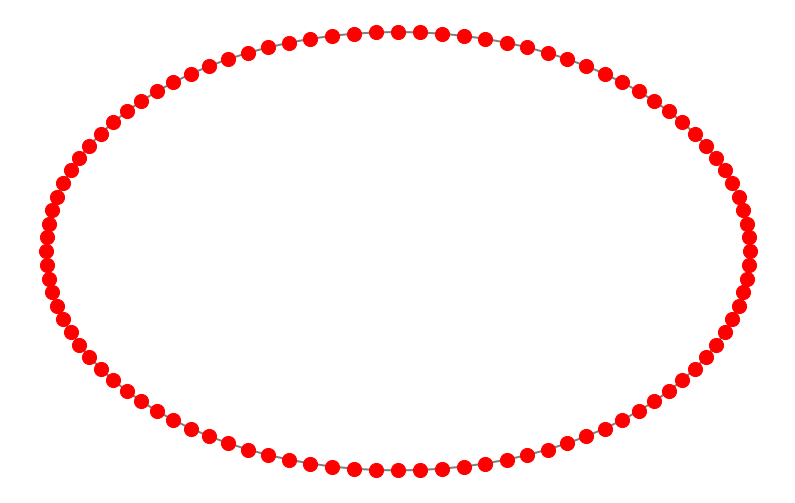

In [18]:
draw_graph(circle)

Construct a `LocalInteraction` class with patoff matrix, which is given by `coordination_game`, and adjacency matrix, which is given by the `circle` dictionary

In [19]:
li_coor_circle = LocalInteraction(coordination_game, circle['adj_matrix'])

Let's look at the process of how action B becomes contagious. At first, only two agents take action B and all other agents take action A. Gradually, all players swich to action B.

Blue color means the agent takes action A, and yellow means action B. As an animation, if one of the neighbors takes action B, he switches to action B from action A.

In [20]:
%%capture

init_actions = np.zeros(li_coor_circle.N, dtype=int)
init_actions[[0, -1]] = 1
num_actions = li_coor_circle.num_actions

fig = plt.figure(figsize=(14,9), facecolor='w')
plt.axis('off')
ax = fig.add_subplot(111)

def get_fig(i, li, init_actions, num_actions):
    nx.draw_networkx_edges(G, pos=circle['pos'], alpha=0.5, width=2, arrows=False, ax=ax)
    current_actions = li.play(actions=init_actions, num_reps=i)
    for m in range(num_actions):
        current_actions = np.asarray(current_actions)
        nodelist = np.where(current_actions==m)[0].tolist()
        nx.draw_networkx_nodes(G=circle['G'], pos=circle['pos'], node_size=200, nodelist=nodelist, node_color=node_colors_2[m], ax=ax)

anim_coor_circle = FuncAnimation(fig, get_fig, fargs=(li_coor_circle, init_actions, num_actions), interval=100, frames=50)

In [21]:
HTML(anim_coor_circle.to_jshtml())

#### Two-dimensional lattice

We next examine another simple graph, called "Two-dimensional lattice". Actually, its procedure for simulation is the same as the circle graph, except for that it is tedious to specify the positions of nodes in this case.

Create `lattice2d` dictionary.

In [22]:
N = 100
lattice2d = {}
m, n = 10, 10
G = nx.grid_2d_graph(m, n)
lattice2d['adj_matrix'] = nx.adjacency_matrix(G)
lattice2d['G'] = nx.Graph(lattice2d['adj_matrix'])
lattice2d['pos'] = {}
for i, (x, y) in enumerate(G.__iter__()):
    lattice2d[(x, y)] = i 
    lattice2d['pos'][i] = (x/(m-1), y/(n-1))

Two-dimensional lattice looks like as folllow:

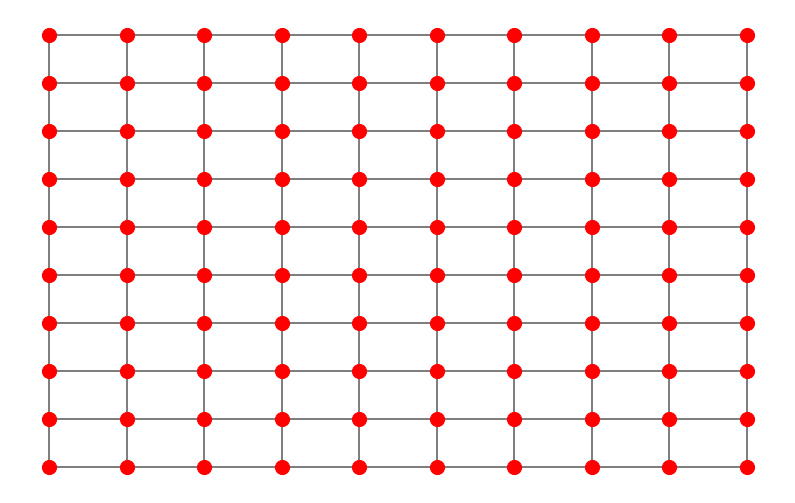

In [23]:
draw_graph(lattice2d)

Construct `LocalInteraction` class of two-dimensional lattice with corresponding payoff matrix and adjacency matrix.

In [24]:
li_coor_lattice2d = LocalInteraction(coordination_game, lattice2d['adj_matrix'])

Again, let's look at how one action becomes contagious. At first, only four agents take actoin B while all other agents take action A. As you can see in the animation, all agents take action B in the end. When two of the neighbors take action B, he switches to action A.

In [25]:
%%capture

init_actions = np.zeros(li_coor_lattice2d.N, dtype=int)
for node in [(m//2-i, n//2-j) for i in range(2) for j in range(2)]:
    init_actions[lattice2d[node]] = 1
num_actions = li_coor_lattice2d.num_actions

fig = plt.figure(figsize=(14,9), facecolor='w')
plt.axis('off')
ax = plt.subplot(111)

def get_fig(i, li, init_actions, num_actions):
    nx.draw_networkx_edges(lattice2d['G'], pos=lattice2d['pos'], alpha=0.5, width=2, arrows=False, ax=ax)
    current_actions = li.play(actions=init_actions, num_reps=i)
    for m in range(num_actions):
        current_actions = np.asarray(current_actions)
        nodelist = np.where(current_actions==m)[0].tolist()
        nx.draw_networkx_nodes(G=lattice2d['G'], pos=lattice2d['pos'], node_size=200, nodelist=nodelist, node_color=node_colors_2[m], ax=ax)


anim_lattice2d = FuncAnimation(fig, get_fig, fargs=(li_coor_lattice2d, init_actions, num_actions), interval=500, frames=10)

In [26]:
HTML(anim_lattice2d.to_jshtml())

### 3-actions case

The `localint` module works even in 3-actions case. Let's consider the following game, which is called "Bilingual Game":

In [27]:
def bilingual_game(e, a=11, b=0, c=9, d=8):
    A = np.array([[a  , a  , b],
                  [a-e, a-e, d-e],
                  [c  , d  , d]])
    return A

In [28]:
bg = bilingual_game(e=0.1)
bg

array([[11. , 11. ,  0. ],
       [10.9, 10.9,  7.9],
       [ 9. ,  8. ,  8. ]])

The scenario of the bilingual game is as follows. Two people can speak Language A or Language B. If they can talk in the same language, they can get high payoff. In addition, they can become able to speak both languages with cost $e$. Therefore, the action set of each player is {Language A, Language A&B, Language B}. In the above matrix, for example, first, second and bottom row correspond to Language A (action 0), Language A&B (action 1) and Language B (action 2) respectively. 

When we assume $b < c \le d \le a$, $a-c < d-b$ and $e >0$, (A, A) and (B,B) are the only pure strategy Nash equilibria. (A,A) Pareto-dominates (B,B), while (B,B) risk-dominates (A,A). By assumption $c \le d$, the game is supermodular with respect to the order A< A&B < B

In [29]:
node_colors_3 = ['b', 'r', 'y']

We show that even the action 0, which leads to Pareto efficient outcome, can be contagious in this case. 

#### Circle

First, lets look at bilingual game on the circle network as defined above.

In [30]:
li_bg_circle = LocalInteraction(bg, circle['adj_matrix'])

In [31]:
%%capture

init_actions = np.ones(li_bg_circle.N, dtype=int) * 2
init_actions[[0, 1, -2, -1]] = 0
num_actions = li_bg_circle.num_actions

fig = plt.figure(figsize=(14,9), facecolor='w')
plt.axis('off')
ax = plt.subplot(111)

def get_fig(i, li, init_actions, num_actions):
    nx.draw_networkx_edges(circle['G'], pos=circle['pos'], alpha=0.5, width=2, arrows=False, ax=ax)
    current_actions = li.play(actions=init_actions, num_reps=i)
    for m in range(num_actions):
        current_actions = np.asarray(current_actions)
        nodelist = np.where(current_actions==m)[0].tolist()
        nx.draw_networkx_nodes(G=circle['G'], pos=circle['pos'], node_size=200, nodelist=nodelist, node_color=node_colors_3[m], ax=ax)


anim_bg_circle = FuncAnimation(fig, get_fig, fargs=(li_bg_circle, init_actions, num_actions), interval=100, frames=50)

In [32]:
HTML(anim_bg_circle.to_jshtml())

As you see in the animation, action 0 becomes contagionus even though only four people take action 0 at first. Agents switches to action 1 from action 0, and to action 2 from action 1.

#### Two-dimensional lattice

Next, we consider the bilingual game in the two-dimensional lattice.

In [33]:
li_bg_lattice2d = LocalInteraction(bg, lattice2d['adj_matrix'])

In [34]:
%%capture

init_actions = np.ones(li_bg_lattice2d.N, dtype=int) * 2
for node in [(m//2-i, n//2-j) for i in range(2) for j in range(2)]:
    init_actions[lattice2d[node]] = 0
num_actions = li_bg_lattice2d.num_actions

fig = plt.figure(figsize=(14,9), facecolor='w')
plt.axis('off')
ax = plt.subplot(111)

def get_fig(i, li, init_actions, num_actions):
    nx.draw_networkx_edges(lattice2d['G'], pos=lattice2d['pos'], alpha=0.5, width=2, arrows=False, ax=ax)
    current_actions = li.play(actions=init_actions, num_reps=i)
    for m in range(num_actions):
        current_actions = np.asarray(current_actions)
        nodelist = np.where(current_actions==m)[0].tolist()
        nx.draw_networkx_nodes(G=lattice2d['G'], pos=lattice2d['pos'], node_size=200, nodelist=nodelist, node_color=node_colors_3[m], ax=ax)


anim_bg_lattice2d = FuncAnimation(fig, get_fig, fargs=(li_bg_lattice2d, init_actions, num_actions), interval=500, frames=11)

In [35]:
HTML(anim_bg_lattice2d.to_jshtml())

Similarly, action 0 becomes contagious finally.

---

## Reference

Oyama, Daisuke and Satoru Takahashi. Contagion and Uninvadability in Local Interaction Games: The Bilingual Game and General Supermodular Games. *Journal of Economic Theory*, 157:100-127, 2015.